In [1]:
%load_ext autoreload
%autoreload 2

from math import pi
from glob import glob

import numpy as np
import matplotlib.pyplot as plt

from root_pandas import read_root

Welcome to JupyROOT 6.10/04


In [2]:
import ROOT

In [3]:
detector_x = [0, 256.35]
detector_x = [-50, 315]
detector_y = [-116.5, 116.5]
detector_z = [0, 1036.8]

In [4]:
plt.rcParams.update({'font.size': 18})

## Useful functions

In [5]:
def point_is_fiducial(x, y, z, fiducial_x=[10, -10], fiducial_y=[20, -20], fiducial_z=[20, -20]):
#     is_x = (detector_x[0] + fiducial_x[0] < df[x]) & (df[x] < detector_x[1] + fiducial_x[1])
    is_y = (detector_y[0] + fiducial_y[0] < df[y]) & (df[y] < detector_y[1] + fiducial_y[1])
    is_z = (detector_z[0] + fiducial_z[0] < df[z]) & (df[z] < detector_z[1] + fiducial_z[1])
    return is_y & is_z

def PitchY(xs,ys,zs,xe,ye,ze):
    sdir = np.array([df[xs],df[ys],df[zs]])
    edir = np.array([df[xe],df[ye],df[ze]])
    tdir = edir-sdir
    tmag = np.sqrt(tdir[0]**2+tdir[1]**2+tdir[2]**2)
    theta = np.arccos(tdir[2]/tmag)
    #theta = np.arccos(tdir.Z())
    return theta

def MediandQdx(x):
    return np.median(x['_dqdx_v'])

## Load datasets

In [6]:
file_dir = "/home/david/data/StopMuCalibration/"
file_list = glob(file_dir+"/throughmu.root")
print file_list

['/home/david/data/StopMuCalibration//throughmu.root']


In [7]:
df = read_root(file_list, key="throughmu/_trk_tree")

Warning in <TClass::Init>: no dictionary for class ROOT::TIOFeatures is available


In [8]:
df['start_is_fiducial'] = point_is_fiducial('_trk_start_x', '_trk_start_y', '_trk_start_z')
df['end_is_fiducial'] = point_is_fiducial('_trk_end_x', '_trk_end_y', '_trk_end_z')

In [9]:
df['start_x_fiducial'] = (detector_x[0] + 10 < df['_trk_start_x']) & (df['_trk_start_x'] < detector_x[1] -10)
df['end_x_fiducial'] = (detector_x[0] + 10 < df['_trk_end_x']) & (df['_trk_end_x'] < detector_x[1] -10)

In [10]:
df['theta'] = PitchY('_trk_start_x','_trk_start_y','_trk_start_z','_trk_end_x','_trk_end_y','_trk_end_z')

In [11]:
df['pitch'] = 0.3/np.cos(df['theta'])#df.apply(lambda x : 0.3/np.cos(df['theta']),axis=1)

In [13]:
df['median_dqdx'] = df.apply(lambda x: MediandQdx(x), axis=1)

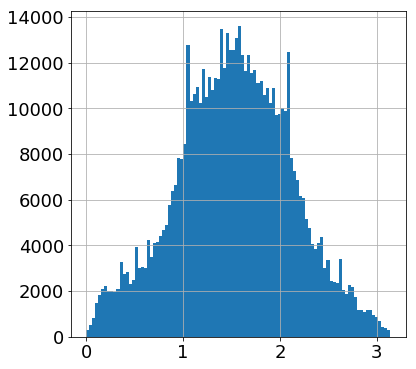

In [14]:
fig = plt.figure(figsize=(6,6))
plt.hist(df['theta'].values,bins=100)
plt.grid()
plt.show()

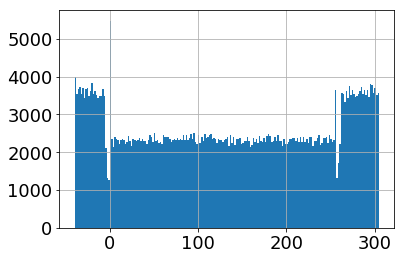

In [15]:
df.query('end_x_fiducial == True')['_trk_end_x'].hist(bins=200)

In [16]:
selected_df = df.query('start_is_fiducial==False & end_is_fiducial==False & _trk_len>50 and _pl==2')

In [17]:
theta_v = selected_df['theta'].values
dqdx_v = selected_df['median_dqdx'].values

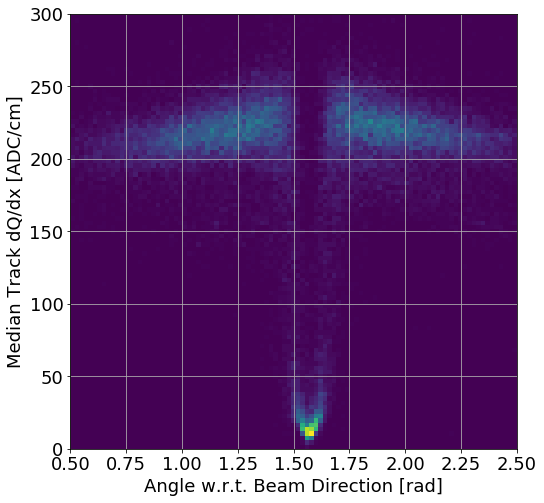

In [18]:
fig = plt.figure(figsize=(8,8))
plt.hist2d(theta_v,dqdx_v,bins=(np.linspace(0.5,2.5,100),np.linspace(0,300,100)))
plt.grid()
plt.xlabel('Angle w.r.t. Beam Direction [rad]')
plt.ylabel('Median Track dQ/dx [ADC/cm]')
plt.show()

In [19]:
pitch_v = np.abs(0.3/np.cos(theta_v))

In [20]:
from matplotlib.colors import LogNorm

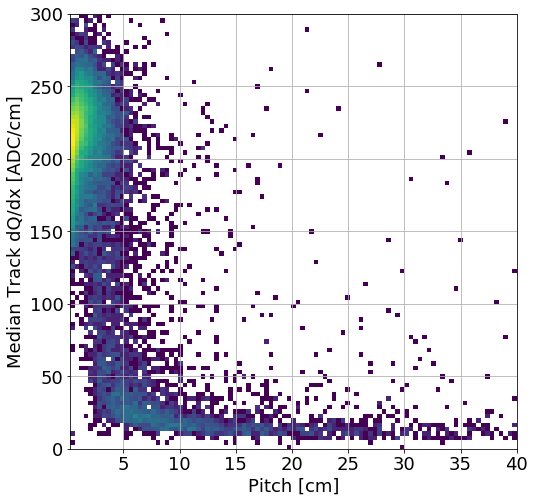

In [21]:
fig = plt.figure(figsize=(8,8))
plt.hist2d(pitch_v,dqdx_v,bins=(np.linspace(0.3,40.0,100),np.linspace(0,300,100)),norm=LogNorm())
plt.grid()
plt.xlabel('Pitch [cm]')
plt.ylabel('Median Track dQ/dx [ADC/cm]')
plt.show()

In [ ]:
dqdx_v = selected_df['_dqdx_v'].values
dqdx_v_flatten = np.hstack(dqdx_v)

rr_v = selected_df['_rr_v'].values
rr_v_flatten = np.hstack(rr_v)

In [ ]:
plt.hist2d(x=rr_v_flatten, y=dqdx_v_flatten, 
           bins=[50, 50],
           range=[[0, 200], [100, 350]],
          )
plt.xlabel("Residual range [cm]")
plt.ylabel("dQ/dx on the Y plane [ADC/cm]")
plt.title("start is not fiducial, end is fiducial, track len > 50 cm")